In [0]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.robust import mad
from tensorflow import keras 
from keras.models import *
from keras.layers import *
from keras import regularizers
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Setting a consistent Random State 
RANDOM_SEED = 42
TIME_STEPS = 7
ANOM_VAL = 2.5
NANOSECONDS = 6e10
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
def pre_process_frequency(input_df):
  """
  Returns the frequence based on time stamp
  """
  dataset = input_df.copy()
  series_dt=pd.Series(dataset.date,dtype='datetime64')
  dataset['date'] = series_dt.view('int64')
  dt_diff = dataset.date.diff().value_counts()
  diff_min = dt_diff.index[0]/NANOSECONDS
  res_freq = str(int(diff_min))+ 'min'
  return res_freq

In [0]:
def pre_process_stdscalar(df):
  """
  Returns the scaled value
  """
  scaler = StandardScaler()
  scaler = scaler.fit(df[['value']])
  df['scaled_value'] = scaler.transform(df[['value']])
  return df['scaled_value'], scaler

In [0]:
def pre_process_timestep(df):
  """
  Creates repetitive sequences based on TIME STEPS
  """
  scaled_data = df.iloc[:, 1:2].values
  x_seq = []
  y_seq = []
  x_comp_seq = []
  for i in range(TIME_STEPS, len(df)):
    x_seq.append(scaled_data[i-TIME_STEPS:i, 0])
    y_seq.append(scaled_data[i, 0])
    x_comp_seq.append(scaled_data[i-TIME_STEPS:i, 0])
  x_comp_seq.append(scaled_data[len(df)-TIME_STEPS:len(df), 0])
  x_seq, y_seq, x_comp_seq  = np.array(x_seq), np.array(y_seq) , np.array(x_comp_seq)
  return x_seq,y_seq,x_comp_seq

In [0]:
def retrieve_dataset(input_array):
  """
  Retrieve the default dimensions 
  from the reshaped array of predictions
  """
  scaled_seq = scaler.inverse_transform((input_array))
  predicted_seq_val = []
  for i in range(len(scaled_seq)):
      value = scaled_seq[i,0,0]
      predicted_seq_val.append(value)
  for i in range (1,TIME_STEPS):
      value = scaled_seq[len(scaled_seq) - 1  ,i,0]
      predicted_seq_val.append(value)
  return np.array(predicted_seq_val)

In [0]:
def model_validation(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

In [0]:
def is_anomaly(res_array, anom_factor):
  upper_limit = np.median(res_array) + mad(res_array)*anom_factor
  lower_limit = np.median(res_array) - mad(res_array)*anom_factor
  return (res_array >=  upper_limit) | (res_array <= lower_limit)

In [0]:
def plot_anomalies():
  plt.plot(
      input_dataframe.index, 
      input_dataframe['value'], 
      label='value'
      );
  sns.scatterplot(
      input_dataframe[(input_dataframe['isAnomaly'] == True)]['value'].index, 
      input_dataframe[(input_dataframe['isAnomaly'] == True)]['value'], 
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
      )
  plt.xticks(rotation=25)
  plt.legend();

In [0]:
#NYC dataset
#input_dataframe = pd.read_csv('/content/drive/My Drive/Colab Notebooks/nyc.csv', parse_dates=['timestamp'])

#SPX dataset
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/spx.csv', parse_dates=['date'], index_col='date')
#df.rename(columns = {'close':'value'}, inplace = True)

#Gold_Price
input_dataframe = pd.read_csv("/content/drive/My Drive/Colab Notebooks/gold_price.csv",parse_dates=['date'])
input_dataframe.rename(columns = {'price_1gm':'value','timestamp' : 'date'}, inplace = True)

In [0]:
freq = pre_process_frequency(input_dataframe)

In [0]:
input_dataframe = input_dataframe.set_index('date').resample(freq).ffill()

In [0]:
#Sorting the input dataframe based on time stamp
input_dataframe = input_dataframe.sort_index()

In [0]:
input_dataframe.shape

(7320, 1)

In [0]:
#Scaling the input dataframe
input_dataframe['scaled_value'],scaler = pre_process_stdscalar(input_dataframe)

In [0]:
#Reshapping the input data frame for LSTM model
x_seq,y_seq,X_cseq = pre_process_timestep(input_dataframe)
x_seq = np.reshape(x_seq, (x_seq.shape[0], x_seq.shape[1], 1))
X_cseq = np.reshape(X_cseq, (X_cseq.shape[0], X_cseq.shape[1], 1))

In [0]:
#Building a Stacked LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units = 64, 
                            activation ='relu', 
                            kernel_initializer=keras.initializers.lecun_uniform(seed=None), 
                            kernel_regularizer=keras.regularizers.l2(l=0.1), 
                            return_sequences = True, 
                            input_shape = (x_seq.shape[1], 1))
)
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units = 64, 
                            activation ='relu', 
                            kernel_initializer=keras.initializers.lecun_uniform(seed=None), 
                            kernel_regularizer=keras.regularizers.l2(l=0.1), 
                            return_sequences = True)
)
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units = 64,  
                            activation ='relu', 
                            return_sequences = True)
)
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units = 64, 
                            activation ='relu' ,  
                            return_sequences = True)
)
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mae')
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 64)             16896     
_________________________________________________________________
dropout (Dropout)            (None, 7, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 64)             33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 64)             33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 64)             3

In [0]:
#Training the LSTM Model
history = model.fit(x_seq, y_seq, epochs=20,
    batch_size=32,
    callbacks=callbacks,
    validation_data= (x_seq,y_seq)
)

Train on 7313 samples, validate on 7313 samples
Epoch 1/20
7313/7313 [==============================] - 9s 1ms/sample - loss: 27.4921 - val_loss: 16.8105
Epoch 2/20
7313/7313 [==============================] - 5s 751us/sample - loss: 13.4352 - val_loss: 10.5644
Epoch 3/20
7313/7313 [==============================] - 5s 737us/sample - loss: 8.5859 - val_loss: 6.7343
Epoch 4/20
7313/7313 [==============================] - 5s 750us/sample - loss: 5.4078 - val_loss: 4.1389
Epoch 5/20
7313/7313 [==============================] - 5s 742us/sample - loss: 3.3217 - val_loss: 2.4767
Epoch 6/20
7313/7313 [==============================] - 6s 757us/sample - loss: 1.9917 - val_loss: 1.4472
Epoch 7/20
7313/7313 [==============================] - 5s 747us/sample - loss: 1.1717 - val_loss: 0.8220
Epoch 8/20
7313/7313 [==============================] - 6s 759us/sample - loss: 0.6905 - val_loss: 0.4678
Epoch 9/20
7313/7313 [==============================] - 5s 719us/sample - loss: 0.4190 - val_loss: 0.2

In [0]:
# Predict the values and update the input dataframe
predicted_seq = model.predict(X_cseq)
input_dataframe['predicted_val'] = retrieve_dataset(predicted_seq)

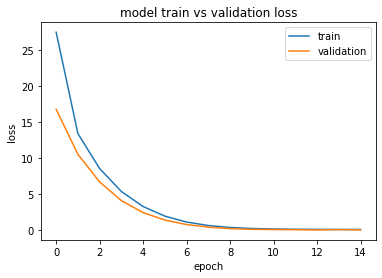

In [0]:
#Evaluating model train and validation loss
model_validation(history)

In [0]:
#Identifying the Anomalies
error_val = input_dataframe['value'] - input_dataframe['predicted_val']
input_dataframe["isAnomaly"] = is_anomaly(error_val,ANOM_VAL)

In [0]:
mae_loss =  np.std(error_val) + np.mean(np.abs(error_val))
print(mae_loss)
print(np.std(error_val))
print(np.mean(np.abs(error_val)))

222.57574340261195
132.6516785651479
89.92406483746404


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


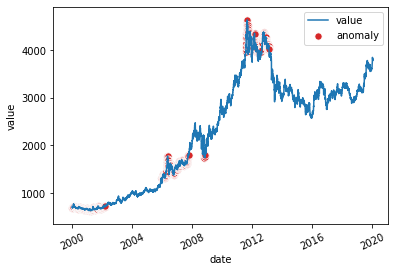

In [0]:
plot_anomalies()

In [0]:
input_dataframe[input_dataframe['isAnomaly']==True]

,value,scaled_value,predicted_val,isAnomaly
date,,,,
2000-01-03,710.612069,-1.390129,878.566895,True
2000-01-04,689.189655,-1.408968,873.526367,True
2000-01-05,686.618966,-1.411228,872.931396,True
2000-01-06,684.048276,-1.413489,872.347656,True
2000-01-07,690.658621,-1.407676,873.866211,True
...,...,...,...,...
2013-02-10,4084.336207,1.576754,3822.798340,True
2013-02-11,4044.551724,1.541768,3813.394287,True
2013-02-12,4033.534483,1.532079,3810.439941,True
